In [23]:
#I sometimes uses these libraries for interactive plots / exploration - they're not necessary for the standard notebook
#import ipywidgets as widgets
#from ipywidgets import interact, interact_manual
#import mplleaflet
#from geopandas import GeoDataFrame
import multiprocessing

In [2]:
from route_shape_process_scripts import get_most_used_shape_id_per_direction, calc_distance
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import boto3
import io
import time
import numpy as np
import math

# point this to your local copy of combined GTFS files --- see notebook `gtfs-realtime/route_shape_process/01_gtfs_transform.ipynb` 

In [3]:
full_routes_gtfs = pd.read_csv("/Users/benjaminmalnor/sandbox/bus350/gtfs-realtime/route_shape_process/input_gtfs/gtfs_routes_2018-08-15_2018-12-12.csv",low_memory=False)
full_trip_stop_schedule = pd.read_csv("/Users/benjaminmalnor/sandbox/bus350/gtfs-realtime/route_shape_process/input_gtfs/gtfs_2018-08-15_2018-12-12.csv",low_memory=False)

In [4]:
#create a quick dictionary to convert route short name (easier to remember) with route_id
route_name_to_id_dict = dict(zip(full_routes_gtfs.route_short_name.tolist(),
                                full_routes_gtfs.route_id.tolist()))

# pick a route and direction

In [69]:
route_of_interest = "40"
direction_of_interest = 1
route_id = route_name_to_id_dict[route_of_interest]
shape_id, trip_headsign = get_most_used_shape_id_per_direction(full_trip_stop_schedule, 
                                                               route_id, 
                                                               direction_of_interest)

# generate the file_name and key to pull the transformed data down from AWS S3

In [70]:
base_key = "route_shape_files/"
csv_name = 'transformed/route_{}_{}_shape_{}_node_trips_w_nearest_2018-08-15_2018-12-11.csv'.format(
                                                route_of_interest,
                                                "".join(trip_headsign.replace("/","-").split(" ")) ,
                                                shape_id)

file_key = base_key+csv_name
file_key

'route_shape_files/transformed/route_40_DowntownSeattleBallard_shape_20040004_node_trips_w_nearest_2018-08-15_2018-12-11.csv'

# Import file from S3

In [71]:
s3 = boto3.client("s3")
bucket_name = "malnor.seattle.bustime"
s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
unpacked_positions_full = pd.read_csv(io.BytesIO(s3_object['Body'].read()))

# calculate the distance between the vehicle observations and the `nearest` shape_pt - there are outlier cases where the vehicle locations is very far from the route and should be removed

In [72]:
unpacked_positions_full['distance_btw_veh_and_shape'] = unpacked_positions_full\
                                                                .apply(lambda x: calc_distance(x['vehicle_lat'],
                                                                x['vehicle_long'], 
                                                                x['shape_pt_lat'],
                                                               x['shape_pt_lon']), axis=1)

# plot the distribution of distances

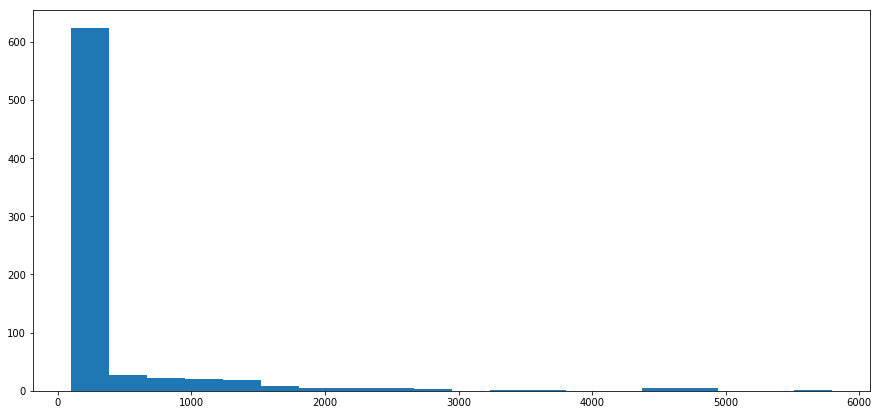

In [73]:
fig, ax = plt.subplots(figsize=(15,7))
_ = ax.hist(unpacked_positions_full\
            [unpacked_positions_full['distance_btw_veh_and_shape']>100]\
            ['distance_btw_veh_and_shape'], bins=20)

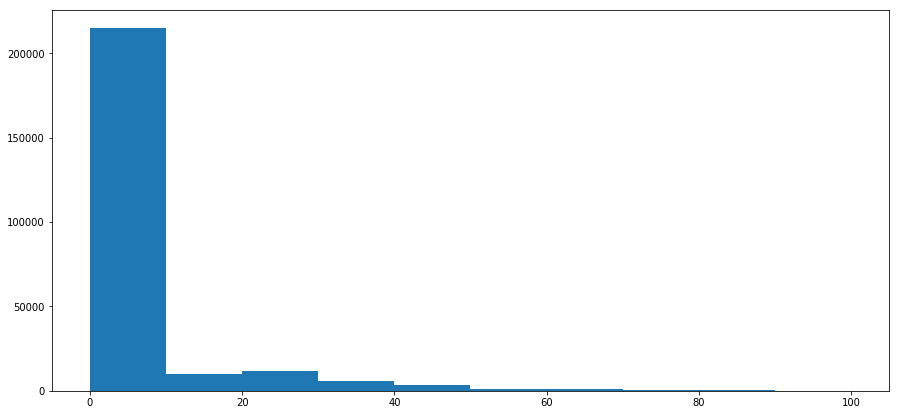

In [74]:
fig, ax = plt.subplots(figsize=(15,7))
_ = ax.hist(unpacked_positions_full\
            [unpacked_positions_full['distance_btw_veh_and_shape']<=100]\
            ['distance_btw_veh_and_shape'])

# FIX MPH - calculate a *new* mph because the original shape_process script was wrong. it's fixed now but the .csv on S3 have the wrong MPH

In [75]:
#Shape_dist_diff/5280 = miles
#Total_seconds_delta/((60 second/min)*(60 min/hour)) = hours
unpacked_positions_full['new_veh_mph'] = unpacked_positions_full\
                        .apply(lambda x: (x['shape_dist_diff']/5280)
                               /(x['total_seconds_delta']/(60*60)) if x['total_seconds_delta'] != 0 else 0, axis=1)

# remove observations where distance between vehicle and shape pt is >100 meters. remove "backwards" trips and remove outlier speeds

In [76]:
unpacked_positions_clean = unpacked_positions_full\
            [(unpacked_positions_full['distance_btw_veh_and_shape']<=100)&
            (unpacked_positions_full['shape_dist_diff']>=0)&
            (unpacked_positions_full['new_veh_mph']>=0)&
            (unpacked_positions_full['new_veh_mph']<80)].copy()
    

# select peak hours and day of week of interest

In [77]:
#Metro “Peak” hours: 6 – 9 a.m. and 3 – 7 p.m
hours_of_interest = [6,7,8,9,15, 16, 17, 18, 19]
#dow - Monday = 0
dow_of_interest = [0,1,2,3,4]
unpacked_positions_clean_hours = unpacked_positions_clean\
                                        [(unpacked_positions_clean['hour'].isin(hours_of_interest))&
                                        (unpacked_positions_clean['dow'].isin(dow_of_interest))]

In [78]:
total_num_trips = len(unpacked_positions_clean_hours['month_day_trip_veh'].unique())
ten_percent_trips = 10 #total_num_trips*.1
shape_pt_obs_count = unpacked_positions_clean_hours.pivot_table(values='new_veh_mph', 
                                      index='month_day_trip_veh', 
                                      columns='shape_pt_sequence',
                                        aggfunc='count')\
                                        .sum(axis=0)
shape_pt_obs_df = pd.DataFrame.from_dict(dict(zip(shape_pt_obs_count.index,
                                                  shape_pt_obs_count.values<ten_percent_trips)), orient='index')

shape_pt_to_keep = shape_pt_obs_df[shape_pt_obs_df[0]==False].index.tolist()


In [79]:
positions_final_clean = unpacked_positions_clean_hours[unpacked_positions_clean_hours['shape_pt_sequence'].isin(shape_pt_to_keep)]

In [106]:
unpacked_positions_clean_hours.columns

Index(['index', 'day', 'direction_id', 'dow', 'hour', 'month',
       'month_day_trip_veh', 'route_id', 'shape_dist_diff',
       'shape_dist_traveled', 'shape_id', 'shape_pt_lat', 'shape_pt_lon',
       'shape_pt_seq_tuple', 'shape_pt_sequence', 'time_delta', 'time_pct',
       'time_utc', 'timestamp', 'total_seconds_delta', 'travel_rate_mph',
       'trip_id', 'vehicle_id', 'vehicle_lat', 'vehicle_long', 'year',
       'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'stop_name', 'stop_lat', 'stop_lon', 'trip_start_time', 'trip_headsign',
       'route_short_name', 'route_desc', 'actual_time_from_scheduled_start',
       'scheduled_time_from_scheduled_start', 'distance_btw_veh_and_shape',
       'new_veh_mph'],
      dtype='object')

In [107]:
unpacked_positions_clean_hours\
                [unpacked_positions_clean_hours['month_day_trip_veh']=='2018_10_10_40954759_8284']\
                [['shape_pt_seq_tuple','shape_dist_traveled','shape_dist_diff','new_veh_mph']]

,shape_pt_seq_tuple,shape_dist_traveled,shape_dist_diff,new_veh_mph
570,"(1, 1)",0.0,0.0,0.000000
571,"(1, 46)",6615.2,6615.2,49.564436
572,"(46, 50)",7293.1,677.9,5.135606
573,"(50, 56)",8773.2,1480.1,11.212879
574,"(56, 78)",11849.7,3076.5,23.306818
575,"(78, 81)",12009.9,160.2,3.309917
576,"(81, 86)",13264.4,1254.5,15.273945
577,"(86, 92)",14459.2,1194.8,9.051515
578,"(92, 105)",18669.9,4210.7,31.548701
579,"(105, 123)",21452.8,2782.9,21.082576


# make a stop_name dictionary - for x_labels on the graph below

In [80]:
stop_name_to_sequence_dict = dict(zip(positions_final_clean.shape_pt_sequence.tolist(),
                        ["" if str(x) == "nan" else x for x in positions_final_clean.stop_name.tolist()]))


# plot average speed across the route

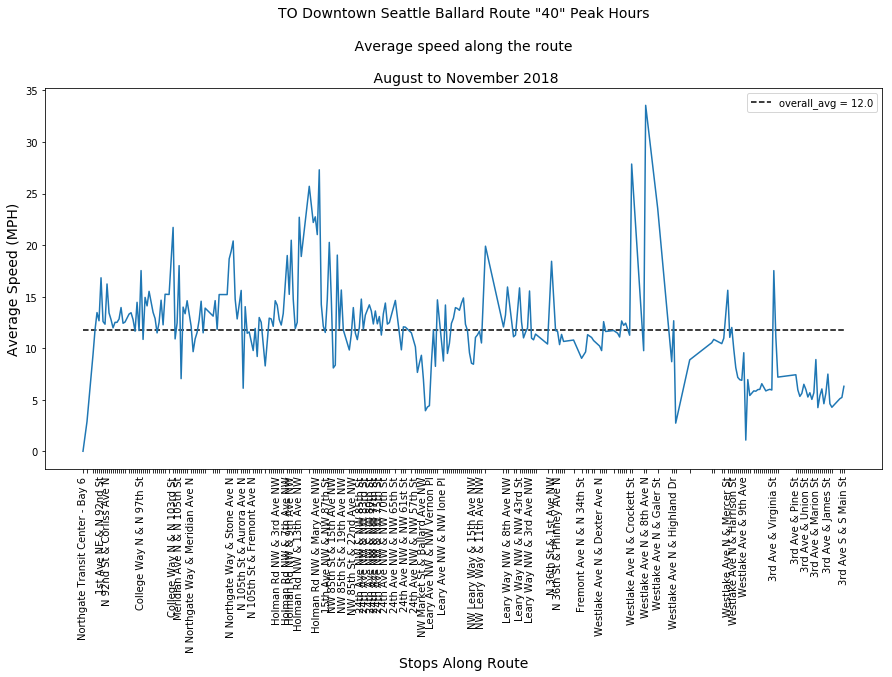

In [81]:
pivot_avg = positions_final_clean.pivot_table(values='new_veh_mph', 
                                      index='month_day_trip_veh', 
                                      columns='shape_pt_sequence')\
                                        .mean(axis=0)
x = pivot_avg.index   
overall_avg = pivot_avg.mean()
x_labels = [stop_name_to_sequence_dict[x_seq] if x_seq in stop_name_to_sequence_dict.keys() else "" for x_seq in x]
fig, ax = plt.subplots(figsize=(15,7))
y_avg = pivot_avg.values

#ax.set_xticklabels(x_labels)
plt.xticks(x, x_labels, rotation='vertical')
ax.plot(x, y_avg)
ax.hlines(overall_avg, xmin=min(x), xmax=max(x)
                          , label='overall_avg = {}'.format(round(overall_avg),1)
                          , linestyles='dashed')
ax.set_ylabel("Average Speed (MPH)", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""TO {} Route \"{}\" Peak Hours
                \n Average speed along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest, hours_of_interest))
ax.legend()
_ = ax.set_title(title_str, fontsize=14)


# flag all trip segments with travel_rate < threshold 

In [94]:
mph_rate_flag = 5 #can change
unpacked_positions_clean_hours_flag = positions_final_clean.copy()
unpacked_positions_clean_hours_flag['trouble_flag'] = unpacked_positions_clean_hours_flag\
                                                                .apply(lambda x: True if x['new_veh_mph'] 
                                                                   < mph_rate_flag else False, axis=1)

# plot slowdown areas with only raw observations

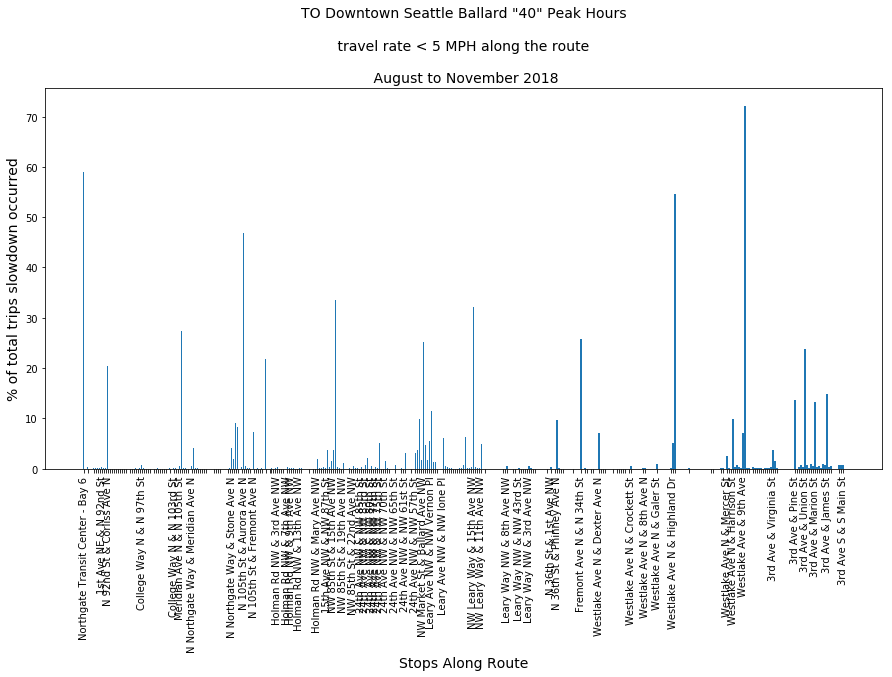

In [95]:
total_trips = len(unpacked_positions_clean_hours_flag.month_day_trip_veh.unique())
pivot_sums = unpacked_positions_clean_hours_flag.pivot_table(values='trouble_flag', 
                                      index='month_day_trip_veh', 
                                      columns='shape_pt_sequence')\
                                        .sum(axis=0)*100/total_trips
x_pos = pivot_sums.index
x_labels = [stop_name_to_sequence_dict[x] if x in stop_name_to_sequence_dict.keys() else "" for x in x_pos]
fig, ax = plt.subplots(figsize=(15,7))

bar_h = pivot_sums.values
#ax.set_xticklabels(x_labels)
plt.xticks(x_pos, x_labels, rotation='vertical')
ax.bar(x_pos, bar_h)
ax.set_ylabel("% of total trips slowdown occurred", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""TO {} \"{}\" Peak Hours
                \n travel rate < 5 MPH along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest, hours_of_interest))
_ = ax.set_title(title_str, fontsize=14)

# ------------------------------------------------------------------------------------

# the code below can take time to run. only run it if you're curious - I kept it in this notebook in case we ever want to go back to interpolating between observations

# you can compare the raw observations to interpolated observation along segments (below). Note:
1. it's time consuming
2. it produces a similar graph

In [109]:
def get_all_segments_parallel(row):
    '''
    '''
    col_list = ['month_day_trip_veh',
                'trip_hour',
               'time_pct',
               'trip_dow',
               'new_veh_mph',
                'pt_seq',
               'real_obv',
               'trouble_spot_flag',
               'pt_tuple']
    
    month_day_trip_veh = row['month_day_trip_veh']
    trip_hour = row['hour']
    time_pct = row['time_pct']
    trip_dow = row['dow']
    trouble_spot = row['trouble_flag']
    travel_rate_mph = row['new_veh_mph']
    pt_tuple = row['shape_pt_seq_tuple']
    
    shape_pt_seq_tuple = row['shape_pt_seq_tuple']\
                        .replace("(","")\
                        .replace(")","")\
                        .strip()\
                        .split(",")
    
    pt_seq_start = int(shape_pt_seq_tuple[0])
    pt_seq_end = int(shape_pt_seq_tuple[1])
    #print(pt_seq_start, pt_seq_end)
    full_edge_df = pd.DataFrame()
    for idx, pt_seq in enumerate(range(pt_seq_start,pt_seq_end)):
        edge_for_upload = []
        if idx == 0:
            real_obv = True
        else:
            real_obv = False
        #print(pt_seq)
        info_tuple = (month_day_trip_veh,
                     trip_hour,
                     time_pct,
                     trip_dow,
                     travel_rate_mph,
                      pt_seq,
                     real_obv,
                     trouble_spot,
                     pt_tuple)
        edge_for_upload.append(info_tuple)
        edge_df = pd.DataFrame(edge_for_upload, columns=col_list)
        #print("len edge_df = {}".format(len(edge_df)))

        
        if full_edge_df.empty:
            full_edge_df = edge_df.copy()
        else:
            full_edge_df = full_edge_df.append(edge_df)
        #print("len full_edge_df = {}".format(len(full_edge_df)))
    return full_edge_df

In [110]:
def get_segments(df):
    n_pools = multiprocessing.cpu_count() - 1
    pool = multiprocessing.Pool(n_pools)
    row_list = []
    for index, row in df.iterrows():
        row_list.append(row)
    full_edge_df = pd.concat(pool.map(get_all_segments_parallel, row_list))
    return full_edge_df

# !WARNING! This can take a long time if you pick a lot of hours to analyze. 

In [98]:
if __name__ == "__main__":
    start = time.time()
    full_edge_df = get_segments(unpacked_positions_clean_hours_flag)
    end = time.time()
    print(end - start)

1438.534828901291


In [99]:
full_edge_df.head()

,month_day_trip_veh,trip_hour,time_pct,trip_dow,new_veh_mph,pt_seq,real_obv,trouble_spot_flag,pt_tuple
0,2018_10_10_40954742_8275,6,2018-10-10 06:00:27-07:00,2,43.134667,171,True,False,"(171, 181)"
0,2018_10_10_40954742_8275,6,2018-10-10 06:00:27-07:00,2,43.134667,172,False,False,"(171, 181)"
0,2018_10_10_40954742_8275,6,2018-10-10 06:00:27-07:00,2,43.134667,173,False,False,"(171, 181)"
0,2018_10_10_40954742_8275,6,2018-10-10 06:00:27-07:00,2,43.134667,174,False,False,"(171, 181)"
0,2018_10_10_40954742_8275,6,2018-10-10 06:00:27-07:00,2,43.134667,175,False,False,"(171, 181)"


# plot avg speed

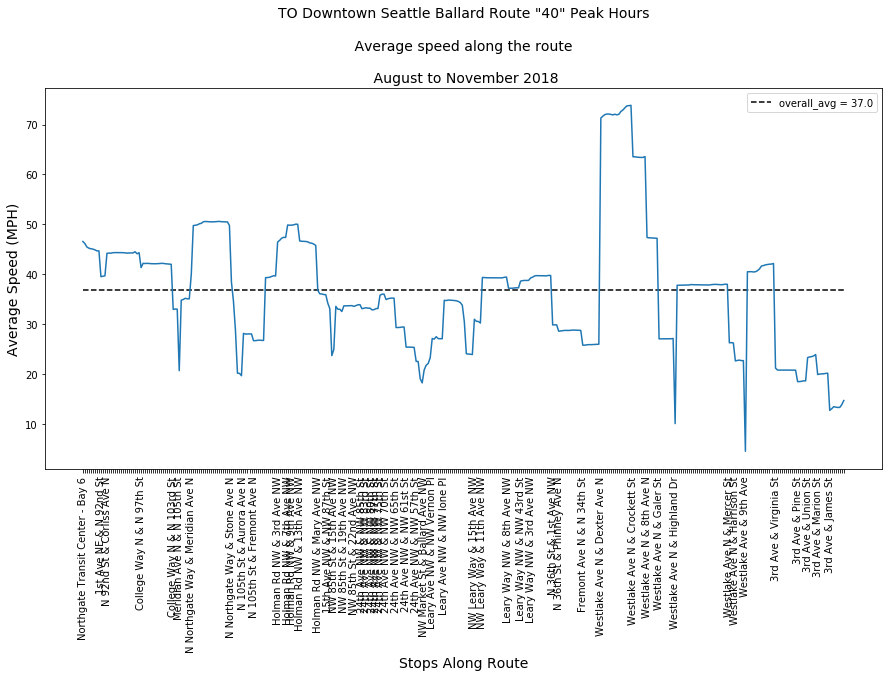

In [101]:
pivot_avg = full_edge_df.pivot_table(values='new_veh_mph',
                                      index='month_day_trip_veh', 
                                      columns='pt_seq')\
                                        .mean(axis=0)
x = pivot_avg.index   
overall_avg = pivot_avg.mean()
x_labels = [stop_name_to_sequence_dict[x_seq] if x_seq in stop_name_to_sequence_dict.keys() else "" for x_seq in x]
fig, ax = plt.subplots(figsize=(15,7))
y_avg = pivot_avg.values

#ax.set_xticklabels(x_labels)
plt.xticks(x, x_labels, rotation='vertical')
ax.plot(x, y_avg)
ax.hlines(overall_avg, xmin=min(x), xmax=max(x)
                          , label='overall_avg = {}'.format(round(overall_avg),1)
                          , linestyles='dashed')
ax.set_ylabel("Average Speed (MPH)", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""TO {} Route \"{}\" Peak Hours
                \n Average speed along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest, hours_of_interest))
ax.legend()
_ = ax.set_title(title_str, fontsize=14)


# plot slowdown areas with interpolated segements

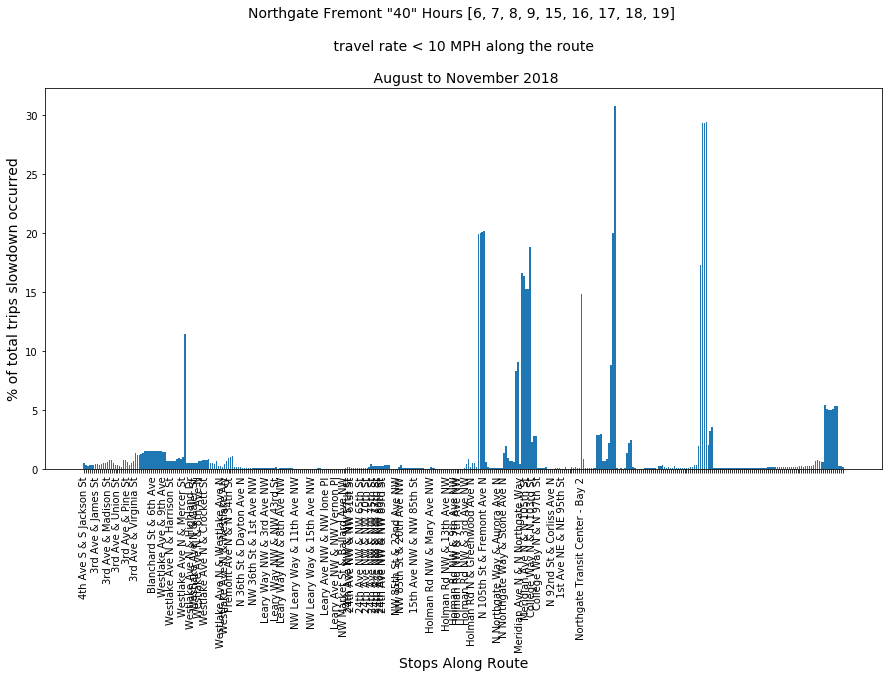

In [29]:
total_trips = len(full_edge_df.month_day_trip_veh.unique())
pivot_sums = full_edge_df.pivot_table(values='trouble_spot_flag', 
                                      index='month_day_trip_veh', 
                                      columns='pt_seq')\
                                        .sum(axis=0)*100/total_trips
x_labels = [stop_name_to_sequence_dict[x] if x in stop_name_to_sequence_dict.keys() else "" for x in x_pos]
fig, ax = plt.subplots(figsize=(15,7))
x_pos = pivot_sums.index
bar_h = pivot_sums.values
#ax.set_xticklabels(x_labels)
plt.xticks(x_pos, x_labels, rotation='vertical')
ax.bar(x_pos, bar_h)
ax.set_ylabel("% of total trips slowdown occurred", fontsize=14)
ax.set_xlabel("Stops Along Route", fontsize=14)
title_str = ("""{} \"{}\" Hours {} 
                \n travel rate < 5 MPH along the route 
                \n August to November 2018""".format(trip_headsign,
                                                    route_of_interest, hours_of_interest))
_ = ax.set_title(title_str, fontsize=14)